In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import parameter

# conv-layer

### 互相相关运算

In [2]:
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros(size=(X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i][j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层
自定义卷积层

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size) -> None:
        super().__init__()
        self.weight = parameter.Parameter(torch.rand(kernel_size)) # self.weight 起到相当于kernel的作用
        self.bias = parameter.Parameter(torch.zeros(1)) # self.bias 是在作用之后做一个整体的偏移
    
    def forward(self, X):
        return corr2d(X, self.weight) + self.bias

### 边缘检测

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
print('X=', X)
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
print('Y=', Y)

X= tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
Y= tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


In [5]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 学习卷积核
这里利用pytorch的卷积层，利用刚才的输入和输出，希望能学习边缘检测的kernel

In [6]:
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1, 2), bias=False) 
X = X.reshape((1, 1, 6, 8)) # 前两个维度分别为batch_size 和 in_channels
Y = Y.reshape((1, 1, 6, 7)) # 前两个维度分别为batch_size 和 out_channels
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 12.838
epoch 4, loss 3.457
epoch 6, loss 1.114
epoch 8, loss 0.406
epoch 10, loss 0.158


In [7]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9456, -1.0260]])

可以看出学习的效果不错

# padding and strides

### 填充
在周围填上0

In [8]:
def comp_conv2d(conv2d, X): # 一个用来计算卷积以及形状变换的辅助函数
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
print(comp_conv2d(conv2d, X).shape)
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
print(comp_conv2d(conv2d, X).shape)

torch.Size([8, 8])
torch.Size([8, 8])


### 步幅
就是卷积核移动的距离，如果卷积核有一部分超出二维数组了，则不进行计算

In [10]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
print(comp_conv2d(conv2d, X).shape)
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
print(comp_conv2d(conv2d, X).shape)

torch.Size([4, 4])
torch.Size([2, 2])


# channels
输入输出通道的维数都与kernel的形状有关

### 多输入通道

In [39]:
def corr2d_multi_in(X, K):
    return sum([corr2d(x, k) for x, k in zip(X, K)])

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道

In [40]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)

K = torch.stack((K, K + 1, K + 2), 0)
print('K.shape=', K.shape)

print(corr2d_multi_in_out(X, K))

K.shape= torch.Size([3, 2, 2, 2])
tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])


### $1\times 1$ 卷积层
$1\times 1$ 卷积层在通道上进行计算

In [41]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
print(float(torch.abs(Y1 - Y2).sum()))

0.0


# pooling

### 最大池化和平均池化

In [42]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros(size=(X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i][j] = (X[i: i + p_h, j: j + p_w]).max()
            elif mode == 'avg':
                Y[i][j] = (X[i: i + p_h, j: j + p_w]).mean()
    return Y


X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
print(pool2d(X, (2, 2)))
print(pool2d(X, (2, 2), 'avg'))

tensor([[4., 5.],
        [7., 8.]])
tensor([[2., 3.],
        [5., 6.]])


### 填充与步幅
默认情况下没有填充，步幅等于池化kernel的形状

In [43]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
pool2d = nn.MaxPool2d(3)
print(pool2d(X))
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
print(pool2d(X))
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1)) # 这里的stride也可以不加，效果相同
print(pool2d(X))

tensor([[[[10.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


### 多个通道
池化不影响通道数量

In [44]:
X = torch.cat((X, X + 1), 1)
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# lenet

### LeNet-5

In [45]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), # 16 是通道数，5，5 分别是是图片的长和宽
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [46]:
batch_size = 256
train_iter, valid_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [47]:
def evaluate_accuracy_gpu(net, data_iter, device=None): # 在验证集或者测试集上计算net的准确率
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device # 读取 net 在哪个设备上
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [48]:
def train_ch6(net, train_iter, valid_iter, num_epochs, lr, device):
    def init_weight(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    print("training on", device)
    net.to(device) # 将网络移到GPU中
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss() 

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'valid acc']) # 用来作图
    timer, num_batches = d2l.Timer(), len(train_iter) # 用来计算处理速度

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # 用来做图的数据记录
        net.train()
        for i, (X, y) in enumerate(train_iter): # 开始训练
            timer.start() # 开始计时
            # 训练关键过程
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, valid_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

loss 0.482, train acc 0.817, test acc 0.812
84017.9 examples/sec on cuda:0


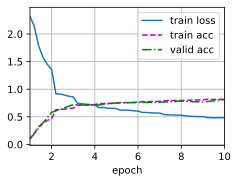

In [49]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, valid_iter, num_epochs, lr, d2l.try_gpu())